In [50]:
!pip install torchmetrics scrapy

In [51]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [52]:
import pandas as pd
import numpy as np
from collections import Counter
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import functools
import json

from transformers import BertTokenizer, BertConfig, BertModel
import pickle  # Added for data storage
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from PIL import Image
from torch.utils.data import Dataset, DataLoader, IterableDataset
import torch.nn as nn
import torchvision
import torch
from sklearn.model_selection import train_test_split
from multiprocessing import Pool
from torchmetrics.functional import pearson_corrcoef

bert_model_name = "setu4993/LaBSE"
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [53]:
path = "/content/drive/MyDrive/RS/ContrastiveLearning/20 epochs 500 dim 0.0001 lr"
# with open(path + '/model.pth', 'rb') as f:
#     model = pickle.load(f)

with open(path + '/foreign_city_embeddings_20ep_500.pickle', 'rb') as f:
    foreign_embeddings_dict = pickle.load(f)

with open(path + '/indian_city_embeddings_20ep_500.pickle', 'rb') as f:
    indian_embeddings_dict = pickle.load(f)

datapath = "/content/drive/MyDrive/RS/Input/"
with open(datapath + 'indian_city_data.json', "r", encoding="utf-8") as f:
    data = json.load(f)
indian_df = pd.DataFrame(data)

with open(datapath + 'foreign_city_data.json', "r", encoding="utf-8") as f:
    data = json.load(f)
foreign_df = pd.DataFrame(data)


In [54]:
# Preprocess text descriptions
def preprocess_text(text):
    text = text.lower()  # Lowercase
    pattern = r'\((?!(mw-parser-output|English|Bengali pronunciation|Kannada pronunciation|IPA|Gujarati|Hindi))[^)]+\)'
    text = re.sub(pattern, '', text)
    text = re.sub(r'[^\w\s]', '', text)
    # Remove stop words
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()

    words = word_tokenize(text)
    filtered_text = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    text = ' '.join(filtered_text)

    return text

In [55]:
def compute_similarity(embedding1, embedding2):
    """Calculates the cosine similarity between two embeddings.

    Args:
        embedding1: A torch.Tensor representing the first embedding.
        embedding2: A torch.Tensor representing the second embedding.

    Returns:
        A float representing the cosine similarity between the two embeddings.
    """
    similarity = pearson_corrcoef(embedding1, embedding2)
    # Access the first element (scalar value) of the tensor
    return similarity.item()

In [56]:
def find_top_similar_cities(indian_embedding, european_embeddings, european_city_names, top_k=5):
    """Finds the top K most similar European cities to a given Indian city based on embedding similarity.

    Args:
        indian_embedding: A torch.Tensor representing the embedding of the Indian city.
        european_embeddings: A torch.Tensor containing the embeddings of all European cities.
        european_city_names: A list of strings containing the names of all European cities.
        top_k: An integer specifying the number of top similar cities to return (default: 5).

    Returns:
        A list of tuples containing (city_name, similarity) for the top K most similar European cities.
    """
    similarities = []
    #indian_embedding = indian_embedding.to(device)
    for i, european_embedding in enumerate(european_embeddings):
        #european_embedding = european_embedding.to(device)

        similarity = compute_similarity(indian_embedding, european_embedding)
        similarities.append((european_city_names[i], similarity))
    similarities.sort(key=lambda x: x[1], reverse=True)  # Sort by similarity (descending)
    return similarities[:top_k]

In [57]:
# Function to calculate word frequencies
def calculate_word_frequencies(text):
    # Tokenize text
    words = text.split()
    # Count word frequencies
    word_freq = Counter(words)
    return word_freq

# Function to generate word cloud
def generate_word_cloud(text, words=50):
    wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis', max_words=words).generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

In [58]:
european_city_embeddings = torch.stack([value for value in foreign_embeddings_dict.values()])  # Convert to tensor on GPU if available
european_city_names = list(foreign_embeddings_dict.keys())

indian_city_embeddings = torch.stack([value for value in indian_embeddings_dict.values()])  # Convert to tensor on GPU if available
indian_city_names = list(indian_embeddings_dict.keys())

In [59]:
def cross_entropy(preds, targets, reduction='none'):
    log_softmax = nn.LogSoftmax(dim=-1)
    loss = (-targets * log_softmax(preds)).sum(1)
    if reduction == "none":
        return loss
    elif reduction == "mean":
        return loss.mean()

In [60]:
class ImageEncoder(nn.Module):
  def __init__(self, pretrained_model_name="resnet50"):
    super(ImageEncoder, self).__init__()
    # Load a pre-trained image classification model (e.g., ResNet50)
    self.resnet = getattr(torchvision.models, pretrained_model_name)(pretrained=True)
    self.out_features = self.resnet.fc.in_features  # Assuming fc is the last layer
    print('Resnet output layer size: ', self.out_features)
    # Remove the last classification layer
    self.resnet.fc = nn.Identity()

  def forward(self, x):
    # Pass image through the pre-trained model (excluding classification layer)
    #print(x.shape)
    x = x.view(-1, x.size(2), x.size(3), x.size(4))
    #print(x.shape)
    x = self.resnet(x)
    return x

class TextEncoder(nn.Module):
    def __init__(self, bert_model_name=bert_model_name):
        super(TextEncoder, self).__init__()
        # Load a pre-trained BERT model
        self.bert = BertModel.from_pretrained(bert_model_name)
        self.bert = self.bert.eval()

        config = BertConfig.from_pretrained(bert_model_name)

        # Get the number of units in the last layer
        self.out_features = config.hidden_size

    def forward(self, x):
        # Encode text using BERT tokenizer
        input_ids = x['input_ids']
        attention_mask = x['attention_mask']
        with torch.no_grad():
            output = self.bert(input_ids=input_ids.squeeze(1), attention_mask=attention_mask.squeeze(1))
        pooled_output = output.pooler_output
        return pooled_output

class ProjectionNetwork(nn.Module):
  def __init__(self, input_dim, hidden_dim, output_dim):
    super(ProjectionNetwork, self).__init__()
    self.fc1 = nn.Linear(input_dim, hidden_dim)
    self.relu = nn.ReLU(inplace=True)
    self.fc2 = nn.Linear(hidden_dim, output_dim)

  def forward(self, x):
    x = self.fc1(x)
    x = self.relu(x)
    x = self.fc2(x)
    return x

class ContrastiveModel(nn.Module):
  def __init__(self, image_encoder, text_encoder, projection_dim, temperature=0.7):
    super(ContrastiveModel, self).__init__()
    self.image_encoder = image_encoder
    self.text_encoder = text_encoder
    self.image_projection = ProjectionNetwork(image_encoder.out_features, 512, projection_dim)
    self.text_projection = ProjectionNetwork(text_encoder.out_features, 512, projection_dim)
    self.temperature = temperature

  def forward(self, images, text):
    # Encode image and text
    #image_features = self.image_encoder(image)
    image_features = self.image_encoder(images)
    text_features = self.text_encoder(text)

#     print('image_features shape: ', image_features.shape)
#     print('text_features shape: ', text_features.shape)

    # Project embeddings to a lower dimension
    image_projections = self.image_projection(image_features)
    text_projections = self.text_projection(text_features)
    text_projections = text_projections.repeat(5, 1)
#     print('image_embeddings shape: ', image_projections.shape)
#     print('text_embeddings shape: ', text_projections.shape)

    image_embeddings = image_projections / torch.norm(image_projections, dim=1, keepdim=True)
    text_embeddings = text_projections / torch.norm(text_projections, dim=1, keepdim=True)

#     print('Image embedding: ', image_embeddings)
#     print('Text embedding: ', text_embeddings)

    # Calculating the Loss
    logits = (text_embeddings @ image_embeddings.T) / self.temperature
    # print('Logits: ', logits)
    images_similarity = image_embeddings @ image_embeddings.T
    texts_similarity = text_embeddings @ text_embeddings.T
    targets = (images_similarity + texts_similarity) / 2 * self.temperature
    # print('Target: ', targets)
    texts_loss = cross_entropy(logits, targets, reduction='none')
    images_loss = cross_entropy(logits.T, targets.T, reduction='none')
    loss =  (images_loss + texts_loss) / 2.0 # shape: (batch_size)
    # print('Batch loss: ', loss.mean())
    return loss.mean()

print("Model architecture defined!")

Model architecture defined!


In [61]:
path = "/content/drive/MyDrive/RS/ContrastiveLearning/20 epochs 500 dim 0.0001 lr"
model = torch.load(path + '/model_20ep_500.pth', map_location=torch.device('cpu'))
model.eval()

ContrastiveModel(
  (image_encoder): ImageEncoder(
    (resnet): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (r

**Inference**

In [62]:
tokenizer = BertTokenizer.from_pretrained(bert_model_name)
%cd /content/drive/MyDrive/RS/NewCityScraper/NewCityScraper/scrapedData
found = False

# Concatenate paragraphs with a newline character
def concatenate_paragraphs(paragraphs):
    return " ".join(paragraphs)

input_city_name = input('Enter the city name: ')
k = int(input('Enter number of European cities to recommend: '))
count = int(input('Enter number of words to display in the word cloud: '))
for city in indian_city_names:
    # Check if the input city matches the city name
    if input_city_name.lower() == city.lower():
        print("Input city found in the list:", city)
        embedding = indian_embeddings_dict[city]
        full_name = city
        found = True
        break

if not found:
    print("Input city not found in the list")
    city_url = input('Enter the city\'s Wikipedia URL: ')
    !scrapy crawl wikipedia -a city={city_name} -a url={city_url} -o output_{input_city_name}.json

    with open(f"/content/drive/MyDrive/RS/NewCityScraper/NewCityScraper/scrapedData/output_{input_city_name}.json", "r", encoding="utf-8") as f:
        data = json.load(f)

    with torch.no_grad():
        text = preprocess_text(data[0]['paragraphs'])
        text_tensors = tokenizer(text, padding="max_length", return_tensors="pt", truncation=True)
        # Forward pass through TextEncoder and projection network (batch processing)5
        text_embeddings = model.text_encoder(text_tensors)
        text_projections = model.text_projection(text_embeddings)
        combined_embeddings = torch.cat([text_embeddings, text_projections], dim=1)
    embedding = combined_embeddings[0]

/content/drive/MyDrive/RS/NewCityScraper/NewCityScraper/scrapedData
Enter the city name: Udaipur
Enter number of European cities to recommend: 10
Enter number of words to display in the word cloud: 75
Input city found in the list: Udaipur


City:  Udaipur
Most common words in Udaipur :
udaipur : 98
city : 81
lake : 35
rajasthan : 27
india : 21
also : 21
state : 15
festival : 15
major : 14
national : 13


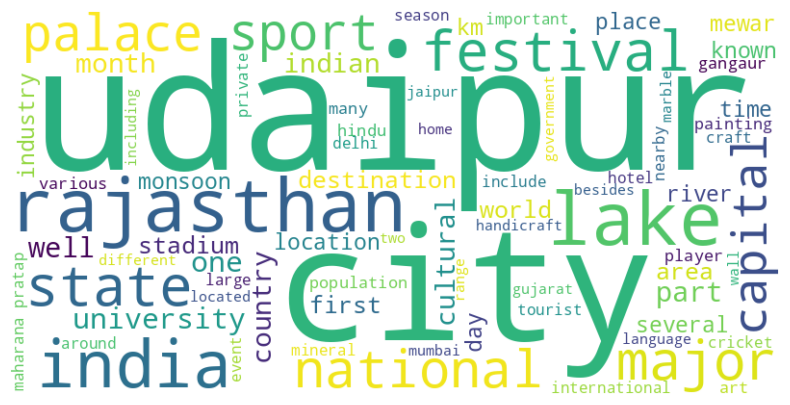


Top 10 similar European cities for Udaipur are:
	- Heidelberg: 0.8111
	- Setúbal: 0.8052
	- Delft: 0.7993
	- Pforzheim: 0.7987
	- Durham: 0.7986
	- Székesfehérvár: 0.7980
	- Leeds: 0.7976
	- Bergen: 0.7970
	- Erlangen: 0.7954
	- Toledo: 0.7927
- Heidelberg: 0.8111
Most common words in Heidelberg :
heidelberg : 131
city : 46
castle : 27
town : 27
german : 24
university : 24
germany : 20
army : 20
part : 16
u : 16


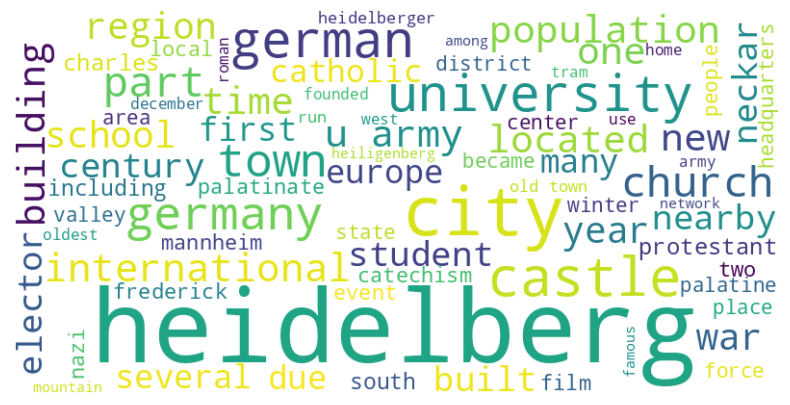



- Setúbal: 0.8052
Most common words in Setúbal :
setúbal : 16
city : 14
c : 6
portugal : 5
river : 5
temperature : 5
municipality : 4
known : 4
port : 4
bank : 4


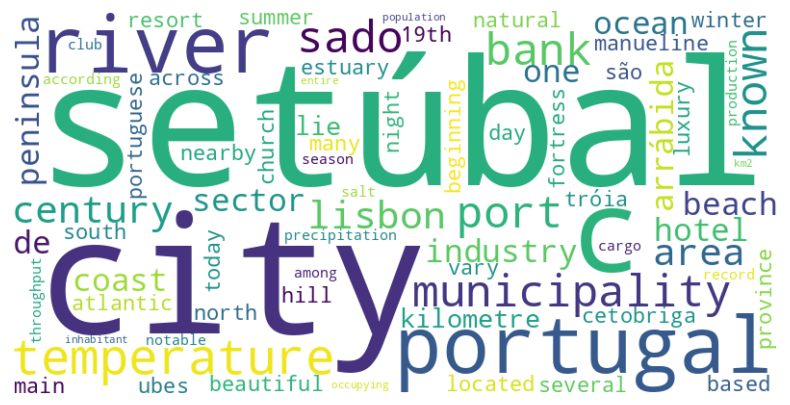



- Delft: 0.7993
Most common words in Delft :
delft : 47
city : 25
university : 8
building : 8
technology : 7
de : 7
also : 7
hague : 6
area : 6
several : 6


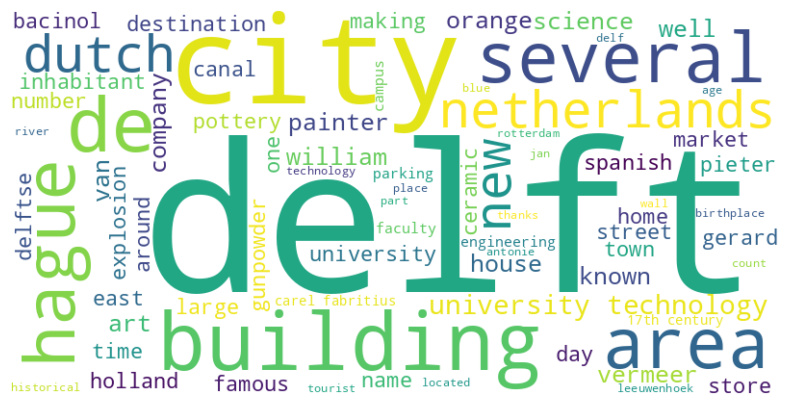



- Pforzheim: 0.7987
Most common words in Pforzheim :
pforzheim : 150
town : 83
city : 49
french : 33
margrave : 28
river : 23
baden : 23
district : 22
area : 20
army : 20


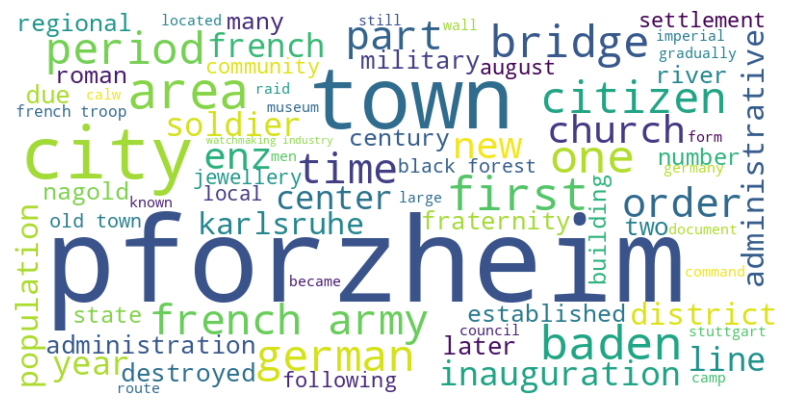



- Durham: 0.7986
Most common words in Durham :
durham : 179
city : 94
bishop : 43
cathedral : 35
university : 33
county : 28
castle : 27
area : 26
club : 25
north : 23


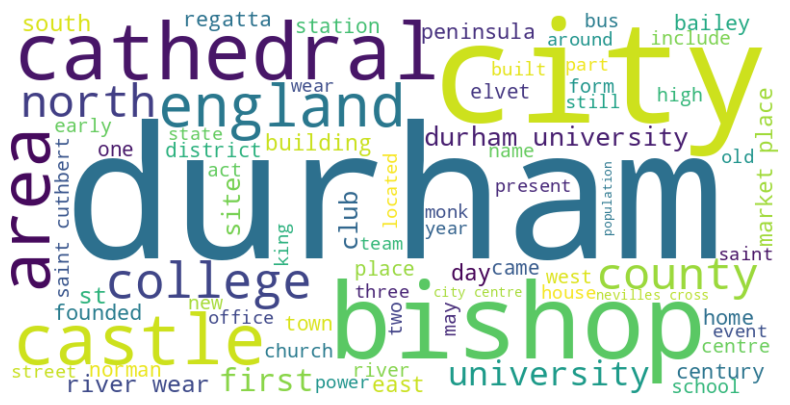



- Székesfehérvár: 0.7980
Most common words in Székesfehérvár :
city : 27
székesfehérvár : 17
hungary : 15
important : 8
century : 8
town : 8
german : 8
king : 7
fehérvár : 6
lake : 6


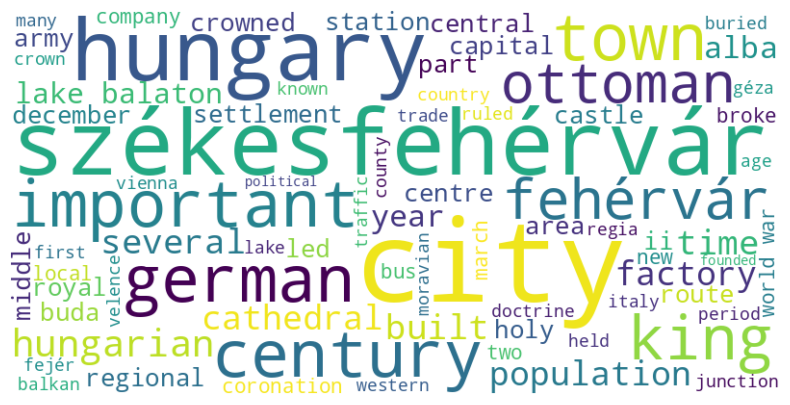



- Leeds: 0.7976
Most common words in Leeds :
leeds : 357
city : 189
centre : 78
area : 63
yorkshire : 47
uk : 47
park : 44
district : 36
west : 32
largest : 32


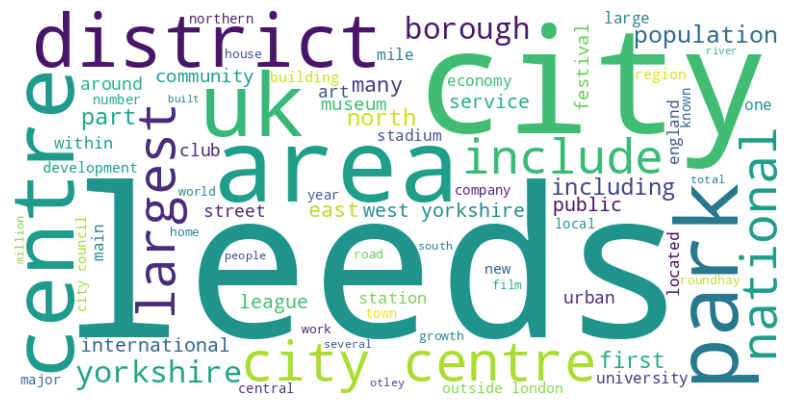



- Bergen: 0.7970
Most common words in Bergen :
bergen : 164
city : 115
norway : 33
norwegian : 29
municipality : 26
population : 23
centre : 23
area : 22
century : 18
mountain : 17


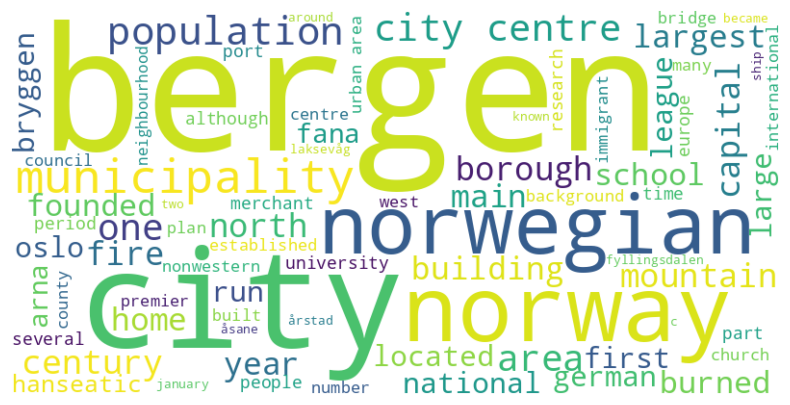



- Erlangen: 0.7954
Most common words in Erlangen :
erlangen : 214
city : 118
town : 47
also : 43
year : 43
first : 42
war : 40
area : 38
new : 36
church : 34


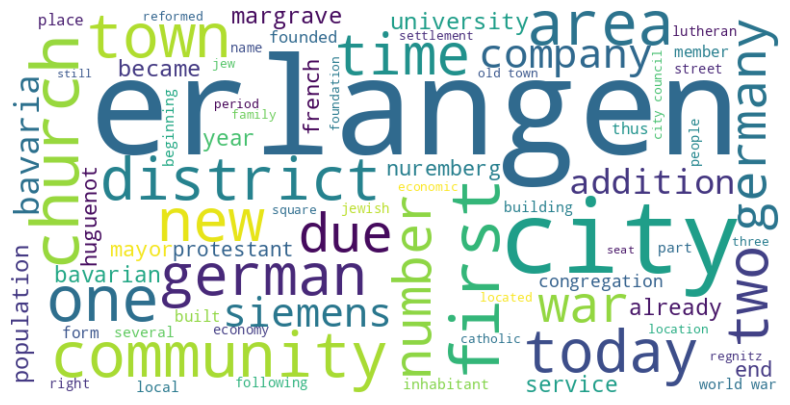



- Toledo: 0.7927
Most common words in Toledo :
toledo : 119
city : 53
de : 31
century : 26
la : 20
mancha : 15
also : 13
centre : 13
santa : 12
spain : 11


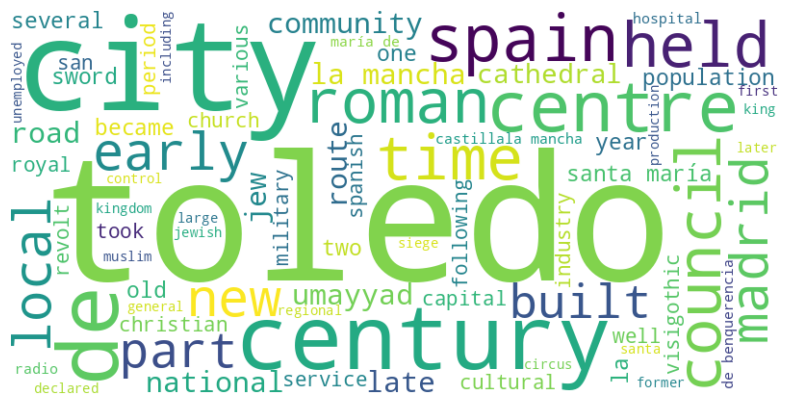

In [63]:
if found:
    print('City: ', input_city_name)
    india_city_row = indian_df[indian_df['city'] == full_name].iloc[0]  # Retrieve the row corresponding to the European city
    india_city_text = india_city_row['paragraphs']  # Extract text from the 'paragraphs' column
    india_city_text = preprocess_text(india_city_text)
else:
    print('City: ', input_city_name)
    india_city_text = preprocess_text(data[0]['paragraphs'])
# Calculate word frequencies
word_freq = calculate_word_frequencies(india_city_text)
# Print the most common words in the European city's text
print("Most common words in", input_city_name, ":")
for word, freq in word_freq.most_common(10):  # Print top 10 most common words
    print(word, ":", freq)

# Generate word cloud for the European city's text
generate_word_cloud(india_city_text, count)
print()

print(f'Top {k} similar European cities for {input_city_name} are:')
top_similar_cities = find_top_similar_cities(embedding, european_city_embeddings, european_city_names, k)
for city_name, similarity in top_similar_cities:
    print(f"\t- {city_name}: {similarity:.4f}")  # Format similarity to 4 decimal places
    euro_city_row = foreign_df[foreign_df['city'] == city_name].iloc[0]  # Retrieve the row corresponding to the European city
    euro_city_text = euro_city_row['paragraphs']  # Extract text from the 'paragraphs' column
    euro_city_text = preprocess_text(euro_city_text)  # Preprocess text

for city_name, similarity in top_similar_cities[:k]:
    print(f"- {city_name}: {similarity:.4f}")  # Format similarity to 4 decimal places
    euro_city_row = foreign_df[foreign_df['city'] == city_name].iloc[0]  # Retrieve the row corresponding to the European city
    euro_city_text = euro_city_row['paragraphs']  # Extract text from the 'paragraphs' column
    euro_city_text = preprocess_text(euro_city_text)
    # Calculate word frequencies
    word_freq = calculate_word_frequencies(euro_city_text)
    # Print the most common words in the European city's text
    print("Most common words in", city_name, ":")
    for word, freq in word_freq.most_common(10):  # Print top 10 most common words
        print(word, ":", freq)

    # Generate word cloud for the European city's text
    generate_word_cloud(euro_city_text, count)
    print()
    print()